In [1]:
import pandas as pd
from dataclasses import dataclass
from rdkit.Chem import (
    Mol,
    MolFromSmiles,
    rdFingerprintGenerator,
    CanonSmiles,
    Descriptors,
)

import numpy as np

from bo_utils import pic50, get_feature_extractors_from_metadata
import matplotlib.pyplot as plt

from fs_mol.data.fsmol_task import GraphData
from fs_mol.preprocessing.featurisers.molgraph_utils import molecule_to_graph
from rdkit import DataStructs
from rdkit.Chem import (
    Mol,
    MolFromSmiles,
    rdFingerprintGenerator,
    CanonSmiles,
    Descriptors,
)
from fs_mol.data import (
    FSMolTask,
    FSMolBatch,
    FSMolBatcher,
)

In [2]:
@dataclass(frozen=True)
class ExtendedMoleculeDatapoint:
    task_name: str
    smiles: str
    graph: GraphData
    numeric_label: float
    bool_label: bool
    fingerprint: np.ndarray
    descriptors: np.ndarray
    scaffold: str
        
    def get_fingerprint(self) -> np.ndarray:
        if self.fingerprint is not None:
            return self.fingerprint
        else:
            # TODO(mabrocks): It would be much faster if these would be computed in preprocessing and just passed through
            mol = Chem.MolFromSmiles(self.smiles)
            fingerprints_vect = rdFingerprintGenerator.GetCountFPs(
                [mol], fpType=rdFingerprintGenerator.MorganFP
            )[0]
            fingerprint = np.zeros((0,), np.float32)  # Generate target pointer to fill
            DataStructs.ConvertToNumpyArray(fingerprints_vect, fingerprint)
            return fingerprint

    def get_descriptors(self) -> np.ndarray:
        if self.descriptors is not None:
            return self.descriptors
        else:
            # TODO(mabrocks): It would be much faster if these would be computed in preprocessing and just passed through
            mol = Chem.MolFromSmiles(self.smiles)
            descriptors = []
            for _, descr_calc_fn in Descriptors._descList:
                descriptors.append(descr_calc_fn(mol))
            return np.array(descriptors)

In [3]:
def get_feature_vector(feature_name):
    return [getattr(datapoint, feature_name) for datapoint in covid_dataset]

In [4]:
def load_covid_moonshot_dataset(csv_file, metadata_path):
    df = pd.read_csv(csv_file, sep=",", header=0)
    #df = df.sort_values(by=["f_avg_IC50"], ascending=True)
    dataset = []

    # get pre-defined atom_feature_extractors from metadata provided in FS-Mol
    atom_feature_extractors = get_feature_extractors_from_metadata(metadata_path)

    for i, row in df.iterrows():

        # get molecule info from the csv file
        raw_numeric_label = float(row["f_avg_IC50"])
        smiles = CanonSmiles(row["SMILES"].strip())
        if np.isnan(raw_numeric_label) or row["chloroacetamide"] or row['acrylamide']:
            continue

        numeric_label = float(pic50(raw_numeric_label))
        scaffold = str(row["series"])
        bool_label = True if raw_numeric_label < 5.0 else False
        
        # get fingerprint
        rdkit_mol = MolFromSmiles(smiles)
        fp_vec = rdFingerprintGenerator.GetCountFPs([rdkit_mol], fpType=rdFingerprintGenerator.MorganFP)[0]
        fp_numpy = np.zeros((0,), np.int8) 
        DataStructs.ConvertToNumpyArray(fp_vec, fp_numpy)
        
        # get graph
        try:
            graph_dict = molecule_to_graph(rdkit_mol, atom_feature_extractors)
            adjacency_lists = []
            for adj_list in graph_dict["adjacency_lists"]:
                if adj_list:
                    adjacency_lists.append(np.array(adj_list, dtype=np.int64))
                else:
                    adjacency_lists.append(np.zeros(shape=(0, 2), dtype=np.int64))
            graph = GraphData(
                node_features=np.array(graph_dict["node_features"], dtype=np.float32), 
                adjacency_lists=adjacency_lists, 
                edge_features=[]
            )
        except IndexError:
            continue

        # get descriptors
        descriptors = []
        for descr in Descriptors._descList:
            _, descr_calc_fn = descr
            descriptors.append(descr_calc_fn(rdkit_mol))
        descriptors = np.array(descriptors, dtype=np.float32)
        
        # create a MoleculeDatapoint object
        mol = ExtendedMoleculeDatapoint(
            task_name="covid_moonshot", smiles=smiles, graph=graph, 
            numeric_label=numeric_label, bool_label=bool_label, 
            fingerprint=fp_numpy, descriptors=descriptors, scaffold=scaffold)
        dataset.append(mol)

    return FSMolTask(name="covid_moonshot", samples=dataset)

In [5]:
csv_file = "covid_moonshot/covid-moonshot-dataset.csv"

covid_task = load_covid_moonshot_dataset(csv_file, "../fs_mol/preprocessing/utils/helper_files/")
covid_dataset = covid_task.samples

In [6]:
numeric_labels = get_feature_vector("numeric_label")
scaffolds = get_feature_vector("scaffold")
scaffold2color = {"nan": "black", "Isatins":"yellow", "activated-ester":"brown", "3-aminopyridine-like": "red", "Ugi": "green", "quinolones": "blue"}
scaffolds_color = [scaffold2color[s] for s in scaffolds]

print(set(scaffolds))
idx = list(range(1, len(scaffolds)+1))

{'Ugi', 'quinolones', '3-aminopyridine-like', 'Isatins', 'activated-ester', 'nan'}


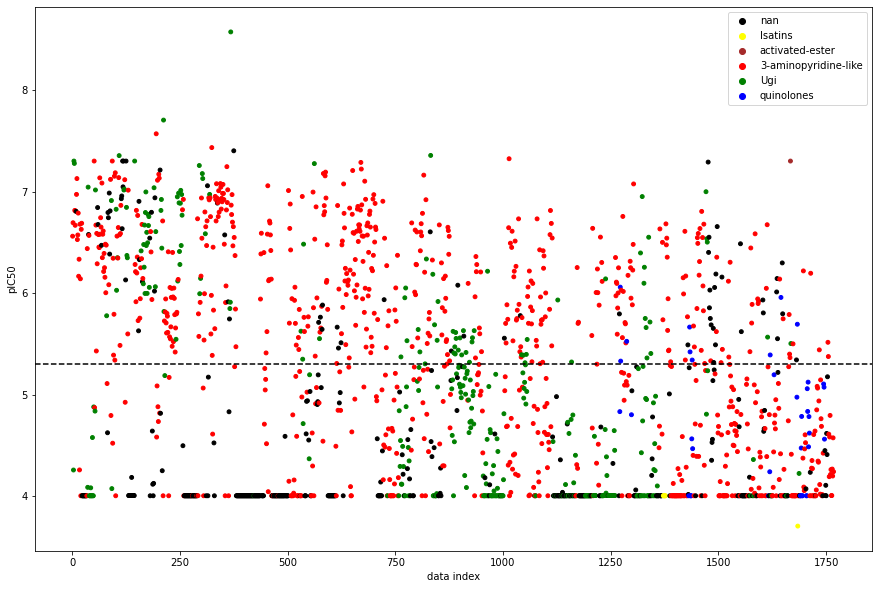

In [7]:
plt.figure(figsize=(15, 10))
plt.xlabel("data index")
plt.ylabel("pIC50")
plt.scatter(idx, numeric_labels, s=15, color=scaffolds_color)
plt.axhline(pic50(5.0), color="black", linestyle="--", label="threshold")
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in scaffold2color.values()]
plt.legend(markers, scaffold2color.keys(), numpoints=1)

In [8]:
from fs_mol.utils.chem_utils import get_binary_fingerprints
from fs_mol.utils.torch_utils import torchify
from fs_mol.utils.metrics import r2_score_os

from botorch.optim.fit import fit_gpytorch_scipy
from bo_utils import create_gp

from scipy.stats import spearmanr
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score
from fs_mol.utils.metrics import r2_score_os
import torch
device = torch.device("cpu")

In [9]:
test_scaffolds = ['Ugi', 'quinolones', '3-aminopyridine-like']

In [10]:
fp_all = get_binary_fingerprints(covid_dataset, True)

x_all = torch.from_numpy(np.array(fp_all)).float().to(device)
y_all = torch.FloatTensor([(float(x.bool_label)*2.0-1.0) for x in covid_dataset]).to(device)

roc_auc_scores = []
for test_scaffold in test_scaffolds:
    for j in range(2):
        training_data_idx = []
        test_data_idx = []
        for i in range(x_all.shape[0]):
            if covid_dataset[i].scaffold == test_scaffold:
                if j == 0:
                    test_data_idx.append(i)
                else:
                    training_data_idx.append(i)
            else:
                if j == 0:
                    training_data_idx.append(i)
                else:
                    test_data_idx.append(i)
        x_train = x_all[training_data_idx]
        y_train = y_all[training_data_idx]
        x_test = x_all[test_data_idx]
        y_test = y_all[test_data_idx]

        likelihood, model, mll = create_gp(x_train, y_train, "tanimoto", device, 0.01, True)
        model.train()
        likelihood.train()
        fit_gpytorch_scipy(mll)
        model.eval()
        likelihood.eval()

        with torch.no_grad():
            y_test_pred = torch.sigmoid(likelihood(model(x_test)).mean).detach().cpu().numpy()

        y_test_true = (y_test + 1.0) / 2.0
        y_test_true = y_test_true.detach().cpu().numpy()

        roc_auc_scores.append(roc_auc_score(y_test_true.squeeze(), y_test_pred.squeeze()))
    

In [11]:
print(roc_auc_scores)
print(sum(roc_auc_scores)/len(roc_auc_scores))

[0.8428108531548213, 0.7999064853921962, 0.6934865900383141, 0.46038635174672066, 0.828194963142561, 0.775207344624202]
0.7333320980164691


In [14]:
y_all = torch.FloatTensor([float(x.numeric_label) for x in covid_dataset]).to(device)

r2s = []
nlls = []
spearmanrs = []
for test_scaffold in test_scaffolds:
    for j in range(2):
        training_data_idx = []
        test_data_idx = []
        for i in range(x_all.shape[0]):
            if covid_dataset[i].scaffold == test_scaffold:
                if j == 0:
                    test_data_idx.append(i)
                else:
                    training_data_idx.append(i)
            else:
                if j == 0:
                    training_data_idx.append(i)
                else:
                    test_data_idx.append(i)
        x_train = x_all[training_data_idx]
        y_train = y_all[training_data_idx]
        x_test = x_all[test_data_idx]
        y_test = y_all[test_data_idx]

        y_train_mean = y_train.mean()
        y_train_std = y_train.std()
        y_train = (y_train - y_train_mean) / y_train_std
        y_test = (y_test - y_train_mean) / y_train_std

        likelihood, model, mll = create_gp(x_train, y_train, "tanimoto", device, 1.0, True)
        model.train()
        likelihood.train()
        fit_gpytorch_scipy(mll)
        model.eval()
        likelihood.eval()

        with torch.no_grad():
            y_test_pred = likelihood(model(x_test))

        r2s.append(r2_score_os(y_test.cpu().detach().numpy(), y_test_pred.mean.cpu().detach().numpy()))
        nlls.append(-y_test_pred.log_prob(y_test).cpu().detach().numpy() / y_test.shape[0])
        spearmanrs.append(spearmanr(y_test.cpu().detach().numpy(), y_test_pred.mean.cpu().detach().numpy())[0])


In [15]:
print(r2s, sum(r2s)/len(r2s))
print(nlls, sum(nlls)/len(nlls))
print(spearmanrs, sum(spearmanrs)/len(spearmanrs))

[0.5170887570427184, 0.40318144049256044, -0.3680138336578789, -0.0042674494017604925, 0.559002673324545, 0.6070408300452137] 0.2856720696408997
[0.9234832333846831, 0.9953442970686526, 0.9419423153525904, 1.516113563656738, 1.146845767372533, 0.985478701228984] 1.0848679796773635
[0.6591166783709524, 0.67248828910598, 0.20590740680932915, -0.007376071766923892, 0.6890847500372881, 0.41457298419209276] 0.4389656727914531


In [16]:
x_all = x_all.detach().cpu().numpy()
y_all = y_all.detach().cpu().numpy()
x_embedded = TSNE(n_components=2, learning_rate='auto', init='pca').fit_transform(x_all)

/scratches/gauss/wc337/miniconda3/envs/fsmol/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


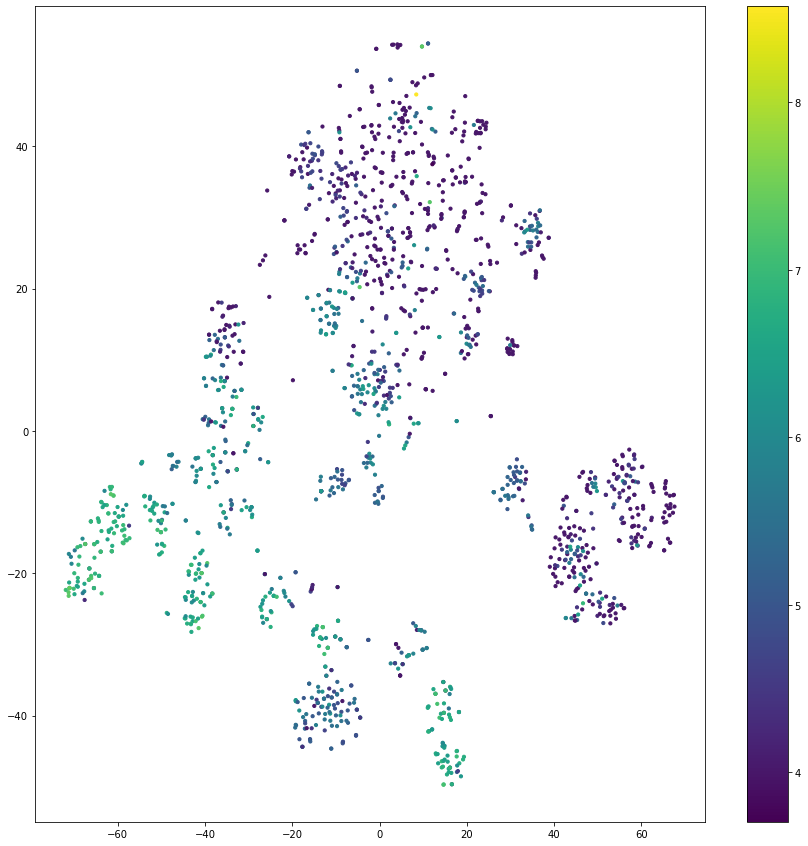

In [17]:
plt.figure(figsize=(15, 15))
plt.scatter(x_embedded[:, 0], x_embedded[:, 1], c=y_all, s=10)
plt.colorbar()

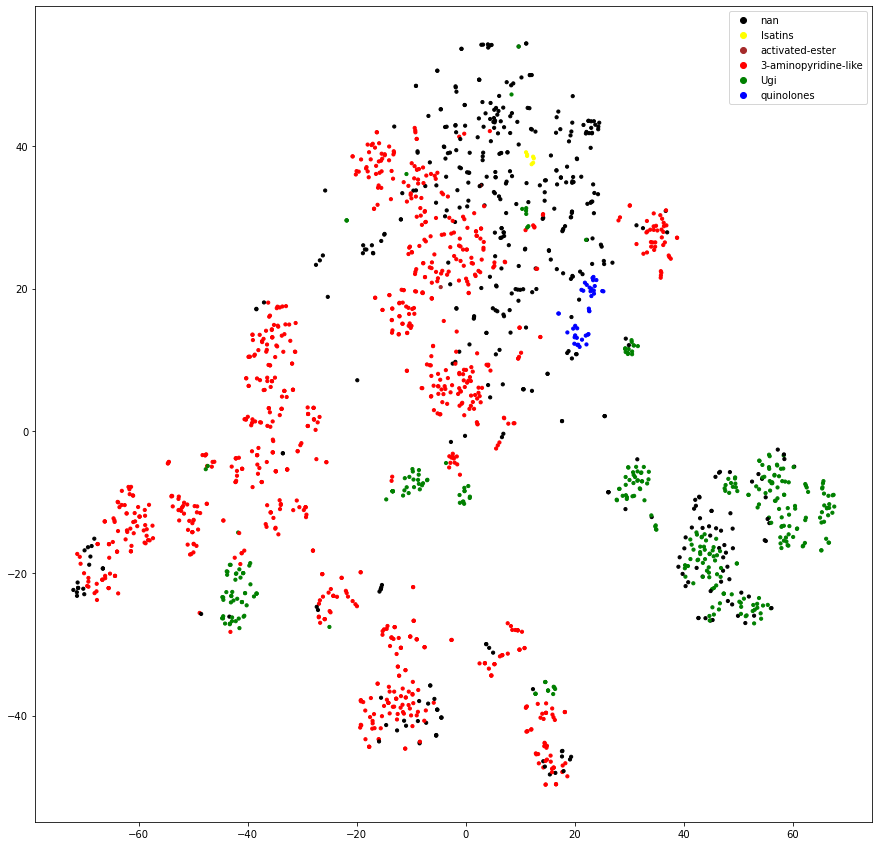

In [18]:
plt.figure(figsize=(15, 15))
plt.scatter(x_embedded[:, 0], x_embedded[:, 1], color=scaffolds_color, s=10)
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in scaffold2color.values()]
plt.legend(markers, scaffold2color.keys(), numpoints=1)

In [19]:
from fs_mol.data.dkt import get_dkt_batcher
from bayes_opt.bo_utils import task_to_batches, ADKTModelFeatureExtractor

In [20]:
batcher = get_dkt_batcher(max_num_graphs=100)
dkt_batches = torchify(
    task_to_batches(covid_task, batcher), 
    device=device
)

#model_weights_file = "../../outputs/FSMol_ADKTModel_gnn+ecfp+fc_2022-03-22_15-28-36/best_validation.pt" #512
model_weights_file = "../outputs/FSMol_ADKTModel_gnn+ecfp+fc_2022-04-07_12-53-41/best_validation.pt" #2048 classification
#model_weights_file = "../../outputs/FSMol_ADKTModel_gnn+ecfp+fc_2022-04-07_17-39-16/best_validation.pt" #2048 regression

adkt_model = ADKTModelFeatureExtractor.build_from_model_file(
    model_weights_file,
    device=device
).to(device)

adkt_model.eval()

representations = []

for features in dkt_batches:
    representation = adkt_model.get_representation(features)
    representations.append(representation)
    
del adkt_model

x_all = torch.cat(representations, dim=0)
y_all = torch.FloatTensor([(float(x.bool_label)*2.0-1.0) for x in covid_dataset]).to(device)

roc_auc_scores = []
for test_scaffold in test_scaffolds:
    for j in range(2):
        training_data_idx = []
        test_data_idx = []
        for i in range(x_all.shape[0]):
            if covid_dataset[i].scaffold == test_scaffold:
                if j == 0:
                    test_data_idx.append(i)
                else:
                    training_data_idx.append(i)
            else:
                if j == 0:
                    training_data_idx.append(i)
                else:
                    test_data_idx.append(i)
        x_train = x_all[training_data_idx]
        y_train = y_all[training_data_idx]
        x_test = x_all[test_data_idx]
        y_test = y_all[test_data_idx]

        likelihood, model, mll = create_gp(x_train, y_train, "matern", device, 0.01, True)
        model.train()
        likelihood.train()
        fit_gpytorch_scipy(mll)
        model.eval()
        likelihood.eval()

        with torch.no_grad():
            y_test_pred = torch.sigmoid(likelihood(model(x_test)).mean).detach().cpu().numpy()

        y_test_true = (y_test + 1.0) / 2.0
        y_test_true = y_test_true.detach().cpu().numpy()

        roc_auc_scores.append(roc_auc_score(y_test_true.squeeze(), y_test_pred.squeeze()))


In [21]:
print(roc_auc_scores)
print(sum(roc_auc_scores)/len(roc_auc_scores))

[0.7975359635379576, 0.8199556062521195, 0.7509578544061304, 0.5456443393850148, 0.8202368848131708, 0.7585856594847846]
0.7488193846465295


In [22]:
y_all = torch.FloatTensor([float(x.numeric_label) for x in covid_dataset]).to(device)

r2s = []
nlls = []
spearmanrs = []
for test_scaffold in test_scaffolds:
    for j in range(2):
        training_data_idx = []
        test_data_idx = []
        for i in range(x_all.shape[0]):
            if covid_dataset[i].scaffold == test_scaffold:
                if j == 0:
                    test_data_idx.append(i)
                else:
                    training_data_idx.append(i)
            else:
                if j == 0:
                    training_data_idx.append(i)
                else:
                    test_data_idx.append(i)
        x_train = x_all[training_data_idx]
        y_train = y_all[training_data_idx]
        x_test = x_all[test_data_idx]
        y_test = y_all[test_data_idx]

        y_train_mean = y_train.mean()
        y_train_std = y_train.std()
        y_train = (y_train - y_train_mean) / y_train_std
        y_test = (y_test - y_train_mean) / y_train_std

        likelihood, model, mll = create_gp(x_train, y_train, "matern", device, 1.0, True)
        model.train()
        likelihood.train()
        fit_gpytorch_scipy(mll)
        model.eval()
        likelihood.eval()

        with torch.no_grad():
            y_test_pred = likelihood(model(x_test))

        r2s.append(r2_score_os(y_test.cpu().detach().numpy(), y_test_pred.mean.cpu().detach().numpy()))
        nlls.append(-y_test_pred.log_prob(y_test).cpu().detach().numpy() / y_test.shape[0])
        spearmanrs.append(spearmanr(y_test.cpu().detach().numpy(), y_test_pred.mean.cpu().detach().numpy())[0])



In [23]:
print(r2s, sum(r2s)/len(r2s))
print(nlls, sum(nlls)/len(nlls))
print(spearmanrs, sum(spearmanrs)/len(spearmanrs))

[0.4817746302583613, 0.36008263707958343, -0.19840301013172268, -0.004186005654766678, 0.5292045899183417, 0.6201254088573922] 0.29809970838786487
[0.9485845861300616, 1.0109299613801346, 0.938607466848273, 1.5997947750234962, 1.1769520274379797, 1.0017291152686403] 1.1127663220147643
[0.5958595902498075, 0.6611982519558404, -0.0014399119357295744, 0.16286049485673165, 0.683107409040908, 0.4996773614948616] 0.4335438659437367


In [24]:
x_all = x_all.detach().cpu().numpy()
y_all = y_all.detach().cpu().numpy()
x_embedded = TSNE(n_components=2, learning_rate='auto', init='pca').fit_transform(x_all)

/scratches/gauss/wc337/miniconda3/envs/fsmol/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


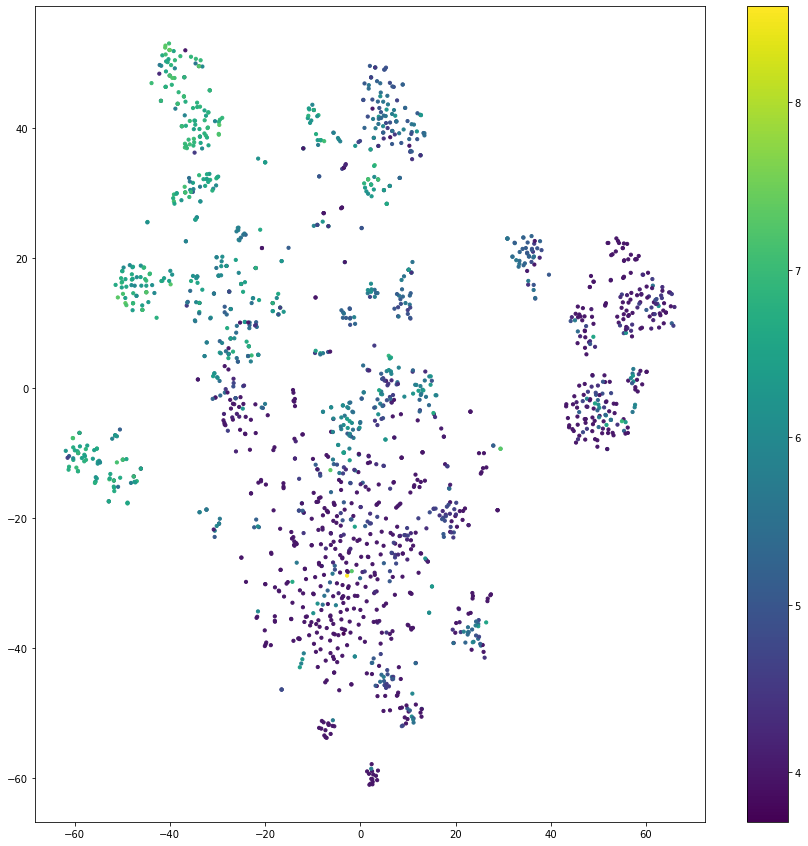

In [25]:
plt.figure(figsize=(15, 15))
plt.scatter(x_embedded[:, 0], x_embedded[:, 1], c=y_all, s=10)
plt.colorbar()

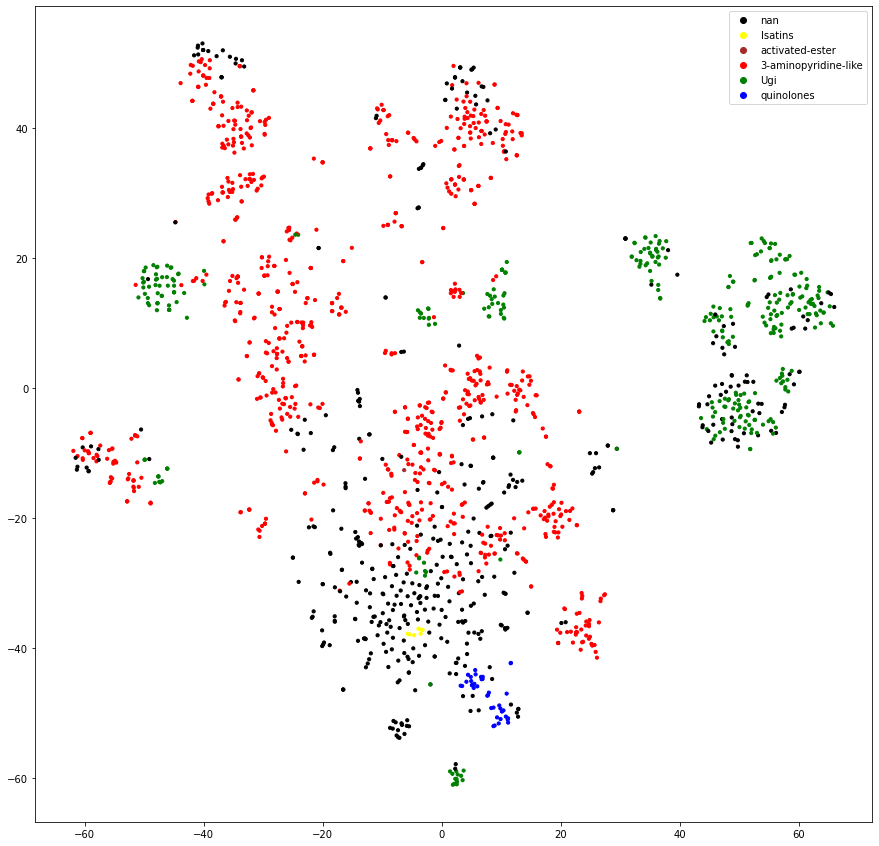

In [26]:
plt.figure(figsize=(15, 15))
plt.scatter(x_embedded[:, 0], x_embedded[:, 1], color=scaffolds_color, s=10)
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in scaffold2color.values()]
plt.legend(markers, scaffold2color.keys(), numpoints=1)